## Import and settings

To run this notebook, install R and mice and set up a PATH to Rscript.exe.

In this example, we need to import numpy, pandas, and matplotlib in addition to lingam.

In [1]:
import os
import sys

path = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(path)

from pruning_missing_data import impute_by_mice, estimate_adj_matrix_for_stacked_imputed_datasets


import numpy as np
import pandas as pd

from IPython.display import display, Markdown
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)
print([np.__version__, pd.__version__])

np.random.seed(100)

['1.24.4', '2.0.3']


## Test data

The following is the adjacency matrix for generating test datasets in this notebook.

In [2]:
m = np.array([
    [ 0.000,  0.000,  0.000,  0.895,  0.000,  0.000],
    [ 0.565,  0.000,  0.377,  0.000,  0.000,  0.000],
    [ 0.000,  0.000,  0.000,  0.895,  0.000,  0.000],
    [ 0.000,  0.000,  0.000,  0.000,  0.000,  0.000],
    [ 0.991,  0.000, -0.124,  0.000,  0.000,  0.000],
    [ 0.895,  0.000,  0.000,  0.000,  0.000,  0.000]
])
causal_order = [3, 0, 2, 1, 4, 5]

display(pd.DataFrame(m).style.background_gradient(axis=None))

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.895000,0.000000,0.000000
1,0.565000,0.000000,0.377000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.895000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.991000,0.000000,-0.124000,0.000000,0.000000,0.000000
5,0.895000,0.000000,0.000000,0.000000,0.000000,0.000000


`impute_by_mice` imputes given data with missing values. The following codes makes a causal data with some missing values.

In [3]:
def generate_data(size=1000):
    scales = [0.2, 0.2, 0.2, 1, 0.2, 0.2]
    e = np.array([np.random.uniform(-np.sqrt(3 * scale), np.sqrt(3 * scale), size=size) for scale in scales])
    X = (np.linalg.pinv(np.eye(len(m)) - m) @ e).T
    return X

def generate_missing_pos(prop_missing):
    # This function generates positions to be missing values by mcar.
    missing_pos = []
    for i, prop in enumerate(prop_missing):
        mask = np.random.uniform(0, 1, size=len(X))
        missing_pos.append(mask < prop)
    missing_pos = np.array(missing_pos).T
    
    return missing_pos

X = generate_data()

prop_missing = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
missing_pos = generate_missing_pos(prop_missing)

# keep true values
true_values = X.copy()
true_values[~missing_pos] = np.nan

X[missing_pos] = np.nan

Actual proportions of missing values are as follows:

In [4]:
np.isnan(X).sum(axis=0) / len(X)

array([0.095, 0.099, 0.098, 0.099, 0.114, 0.103])

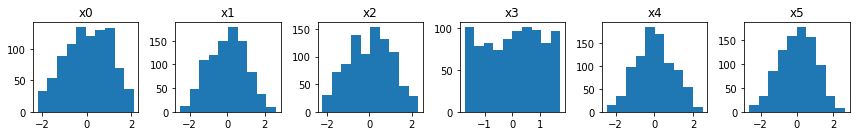

In [5]:
fig, axes = plt.subplots(1, X.shape[1], figsize=(12, 2))
for i, (ax, x) in enumerate(zip(axes, X.T)):
    ax.hist(x)
    ax.set_title(f"x{i}")
plt.tight_layout()
plt.show()

## Impute data

The following codes impute missing values of the data.

In [6]:
X_list = impute_by_mice(X, n_imputations=3)

`impute_by_mice` returns a list of imputed data. Its length is equal to `n_imputations`.

In [7]:
len(X_list)

3

The following codes visualize the relations of imputed values and true values. The horizontal axis is true values and the vertical axis is imputed values.

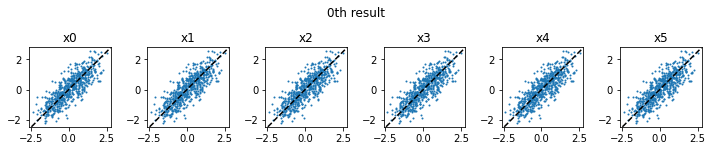

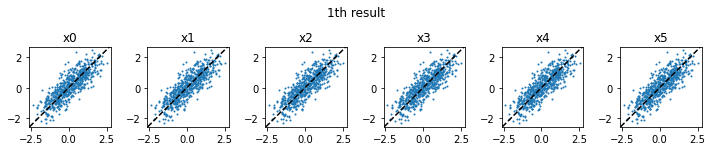

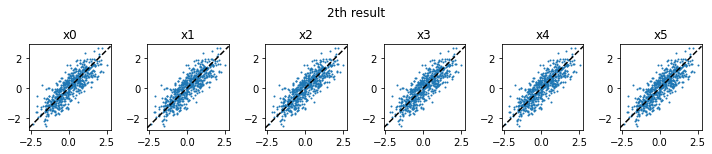

In [8]:
for i, X_imp in enumerate(X_list):
    fig, axes = plt.subplots(1, X.shape[1], figsize=(10, 2))
    for j, ax in enumerate(axes):
        ax.scatter(true_values[missing_pos], X_imp[missing_pos], s=1)
        ax.axline((0, 0), (1, 1), color="black", ls="dashed")
        ax.set_aspect("equal", "box")
        ax.set_title(f"x{j}")
    plt.suptitle(f"{i}th result")
    plt.tight_layout()
    plt.show()

The result of the imputation looks about right.

## Causal discovery on the dataset with missing data

To execute the following code, version 1.9.2 or later lingam package is required.

`lingam.tools.bootstrap_with_imputation` performs a causal discovery with `MultiGroupDirectLiNGAM` on the datasets generated by the multiple imputation to estimate the causal order, and then performs pruning on each of the datasets.

This section describes how to set `impute_by_mice` to `bootstrap_with_imputation` as the alternative imputer.

In [9]:
# install lingam package
#%pip install "lingam>=1.9.2"

from lingam import MultiGroupDirectLiNGAM
from lingam.bootstrap import BootstrapResult
from lingam.tools import BaseMultipleImputation, bootstrap_with_imputation
from lingam.utils import calculate_total_effect, print_causal_directions, print_dagc, make_dot

`bootstrap_with_imputation` is performed to obtain estimation results.

In [10]:
# number of bootstrap sampling
n_sampling = 10
# number of multiple imputations
n_repeats = 10

# see the manual of lingam package for details of bootstrap_with_imputation
result = bootstrap_with_imputation(X, n_sampling, n_repeats)

causal_orders, adj_matrices_list, resampled_indices, imputation_results = result

In [11]:
causal_orders

array([[3, 2, 0, 4, 1, 5],
       [3, 0, 2, 5, 4, 1],
       [3, 0, 2, 5, 4, 1],
       [3, 2, 0, 5, 4, 1],
       [3, 2, 0, 4, 5, 1],
       [3, 0, 2, 1, 5, 4],
       [3, 2, 0, 4, 1, 5],
       [3, 2, 0, 5, 4, 1],
       [3, 0, 2, 1, 5, 4],
       [3, 2, 0, 4, 5, 1]])

`bootstrap_with_imputation` performs the multiple imputation using `sklearn.impute.IterativeImputer`.

The following code sets up an alternative multiple imputation method for `bootstrap_with_imputation`.

In [12]:
class CustomizedMultipleImputation(BaseMultipleImputation):
    
    def fit_transform(self, X):
        X_ = impute_by_mice(X)
        return X_

imp = CustomizedMultipleImputation()
result = bootstrap_with_imputation(X, n_sampling, n_repeats, imp=imp)

causal_orders, adj_matrices_list, resampled_indices, imputation_results = result

In [13]:
causal_orders

array([[3, 0, 2, 5, 4, 1],
       [3, 0, 2, 4, 1, 5],
       [3, 0, 2, 4, 1, 5],
       [3, 0, 2, 4, 1, 5],
       [3, 2, 0, 4, 5, 1],
       [3, 0, 5, 2, 4, 1],
       [3, 0, 2, 4, 1, 5],
       [3, 0, 2, 4, 1, 5],
       [3, 0, 2, 1, 4, 5],
       [3, 0, 2, 4, 5, 1]])

The `adj_matrices_list` will hold the bootstrap results of _`n_sampling` * `n_repeats`_ times. To visualize the results of the bootstrap, execute the following code.

For more information on `lingam.bootstrap.BootstrapResult`, check the `lingam` [manual](https://lingam.readthedocs.io/en/stable/reference/bootstrap.html) and [samples](https://github.com/cdt15/lingam/blob/master/lingam/bootstrap.py).

In [14]:
adj_matrices_list.shape

(10, 10, 6, 6)

In [15]:
# calculate total effect
adj_matrix_list = adj_matrices_list.reshape(-1, 6, 6)

total_effect = np.zeros(adj_matrix_list.shape)
for i, (causal_order, adj) in enumerate(zip(causal_orders, adj_matrix_list)):
    for j, from_ in enumerate(causal_order):
        for to in causal_order[j + 1 :]:
            eff = calculate_total_effect(adj, from_, to)
            total_effect[i, to, from_] = eff

bs_result = BootstrapResult(adj_matrix_list, total_effect)

### Causal directions

In [16]:
cdc = bs_result.get_causal_direction_counts()

print_causal_directions(cdc, n_sampling=len(adj_matrix_list))

x2 <--- x3  (100.0%)
x0 <--- x3  (100.0%)
x1 <--- x0  (100.0%)
x1 <--- x2  (100.0%)
x5 <--- x0  (100.0%)
x4 <--- x0  (100.0%)
x4 <--- x2  (93.0%)
x4 <--- x3  (34.0%)
x5 <--- x2  (18.0%)
x5 <--- x1  (17.0%)
x5 <--- x3  (16.0%)
x2 <--- x0  (15.0%)
x1 <--- x4  (11.0%)
x1 <--- x5  (8.0%)
x1 <--- x3  (5.0%)
x0 <--- x2  (3.0%)
x4 <--- x5  (1.0%)
x2 <--- x5  (1.0%)


### Directed acyclic graphs

In [17]:
dagc = bs_result.get_directed_acyclic_graph_counts(n_dags=3)
print_dagc(dagc, n_sampling=len(adj_matrix_list))

DAG[0]: 20.0%
	x0 <--- x3 
	x1 <--- x0 
	x1 <--- x2 
	x2 <--- x3 
	x4 <--- x0 
	x4 <--- x2 
	x4 <--- x3 
	x5 <--- x0 
DAG[1]: 15.0%
	x0 <--- x3 
	x1 <--- x0 
	x1 <--- x2 
	x2 <--- x3 
	x4 <--- x0 
	x4 <--- x2 
	x5 <--- x0 
	x5 <--- x2 
DAG[2]: 9.0%
	x0 <--- x3 
	x1 <--- x0 
	x1 <--- x2 
	x2 <--- x3 
	x4 <--- x0 
	x4 <--- x2 
	x5 <--- x0 
	x5 <--- x1 


### Probability

In [18]:
prob = bs_result.get_probabilities(min_causal_effect=0.01)
prob

array([[0.  , 0.  , 0.03, 1.  , 0.  , 0.  ],
       [1.  , 0.  , 1.  , 0.05, 0.11, 0.08],
       [0.15, 0.  , 0.  , 1.  , 0.  , 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.93, 0.34, 0.  , 0.01],
       [1.  , 0.17, 0.18, 0.16, 0.  , 0.  ]])

### Total causal effects

In [19]:
causal_effects = bs_result.get_total_causal_effects(min_causal_effect=0.01)
pd.DataFrame(causal_effects).sort_values("effect", key=abs, ascending=False).head()

,from,to,effect,probability
4,3,2,0.882852,0.1
7,0,5,0.868056,0.1
0,3,0,0.866857,0.1
5,0,4,0.823163,0.1
3,3,1,0.794866,0.1


### Bootstrap probability of path

In [20]:
from_index = 3 # index of x3
to_index = 1 # index of x0

pd.DataFrame(bs_result.get_paths(from_index, to_index)).sort_values("effect", key=abs, ascending=False).head()

,path,effect,probability
0,"[3, 0, 1]",0.445459,1.00
1,"[3, 2, 1]",0.376023,1.00
7,"[3, 1]",-0.138457,0.05
6,"[3, 0, 5, 1]",0.083817,0.08
3,"[3, 0, 4, 1]",0.072407,0.11
